In [3]:
# Reload modules
%load_ext autoreload
%autoreload 2

In [4]:
import pandas as pd
import numpy as np
from sklearn import svm
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from defense import train_test_split, train_defense_classifier, test_model, threshold_baseline, get_best_threshold
from util_plotting import plot_mse_predictions, plot_mse_vs_confidence, better_plot_wdr, plot_confidence_histogram


In [36]:
def load_csv(csv_path):
    df = pd.read_csv(csv_path)
    try:
        df["logit_diffs"] = [np.array(eval(','.join(row["logit_diffs"].split()))) for _, row in df.iterrows()]
    except:
        df["logit_diffs"] = [np.array(eval(row["logit_diffs"].replace(";", ","))) for _, row in df.iterrows()]
    
    return df

base = load_csv("base_logit_diffs.csv")
adversarial = load_csv("adversarial_logit_diffs.csv")
far_boundary = load_csv("far_boundary_logit_diffs.csv")
very_far_boundary = load_csv("very_far_boundary_logit_diffs.csv")
very_very_far_boundary = load_csv("very_very_far_boundary_logit_diffs.csv")

In [37]:
low_confidence_base = base[base["confidence"] < 0.8]
very_high_confidence_base = base[base["confidence"] > 0.97]
very_very_high_confidence_base = base[base["confidence"] > 0.997]

In [38]:
# filter out the ones with confidence < 0.5
base = base[base["confidence"] > 0.5]
adversarial = adversarial[adversarial["confidence"] > 0.5]
far_boundary = far_boundary[far_boundary["confidence"] > 0.8]
very_far_boundary = very_far_boundary[very_far_boundary["confidence"] > 0.97]
very_very_far_boundary = very_very_far_boundary[very_very_far_boundary["confidence"] > 0.997]

low_confidence_base = low_confidence_base[low_confidence_base["confidence"] > 0.5]

In [8]:
base.head()

,logit_diffs,is_adversarial,is_adversarial_success,text,confidence
0,"[5.77769756, 6.04660416, 6.58319664, 6.6471090...",False,False,I love sci-fi and am willing to put up with a ...,0.998834
1,"[3.95301652, 4.05837154, 4.30562973, 4.3743863...",False,False,"[[Worth]] the entertainment value of a rental,...",0.992764
2,"[3.67921662, 4.28683853, 4.50494146, 4.5423278...",False,False,its a totally average film with a few semi-alr...,0.993402
3,"[6.67397118, 6.75999546, 6.78043842, 6.7812657...",False,False,STAR RATING: ***** Saturday Night **** Friday ...,0.998911
5,"[4.12109089, 4.37859058, 4.40275621, 4.4232211...",False,False,I had high hopes for this one until they chang...,0.993648


In [9]:
base["confidence"].describe()

count    1141.000000
mean        0.976624
std         0.072032
min         0.500437
25%         0.993715
50%         0.998046
75%         0.998790
max         0.999211
Name: confidence, dtype: float64

In [10]:
low_confidence_base["confidence"].describe()

count    41.000000
mean      0.640606
std       0.092014
min       0.500437
25%       0.554037
50%       0.631224
75%       0.707484
max       0.783460
Name: confidence, dtype: float64

In [11]:
very_high_confidence_base["confidence"].describe()

count    994.000000
mean       0.996428
std        0.004744
min        0.971290
25%        0.996494
50%        0.998349
75%        0.998839
max        0.999211
Name: confidence, dtype: float64

In [12]:
very_far_boundary["confidence"].describe()

count    2760.000000
mean        0.981814
std         0.004666
min         0.970380
25%         0.978195
50%         0.980228
75%         0.984014
max         0.998656
Name: confidence, dtype: float64

In [13]:
very_very_far_boundary["confidence"].describe()

count    932.000000
mean       0.998531
std        0.000094
min        0.997519
25%        0.998508
50%        0.998525
75%        0.998554
max        0.998839
Name: confidence, dtype: float64

In [14]:
very_very_high_confidence_base["confidence"].describe()

count    713.000000
mean       0.998511
std        0.000530
min        0.997011
25%        0.998202
50%        0.998683
75%        0.998925
max        0.999211
Name: confidence, dtype: float64

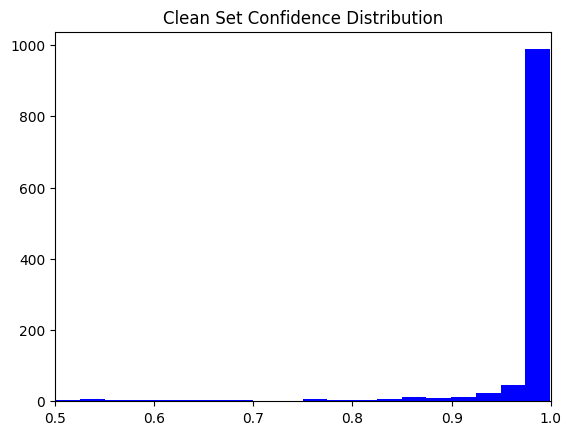

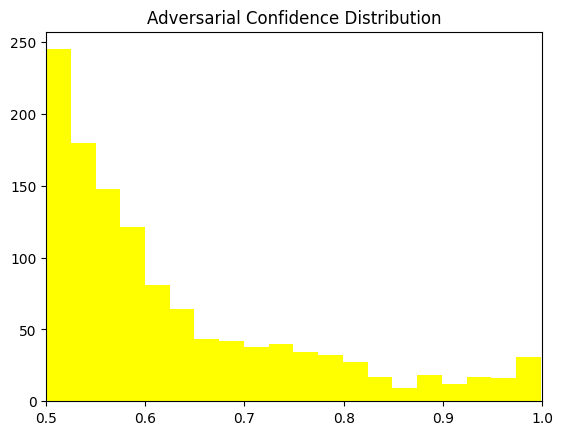

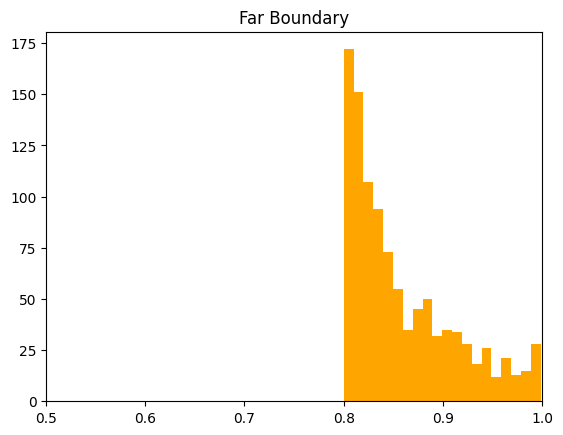

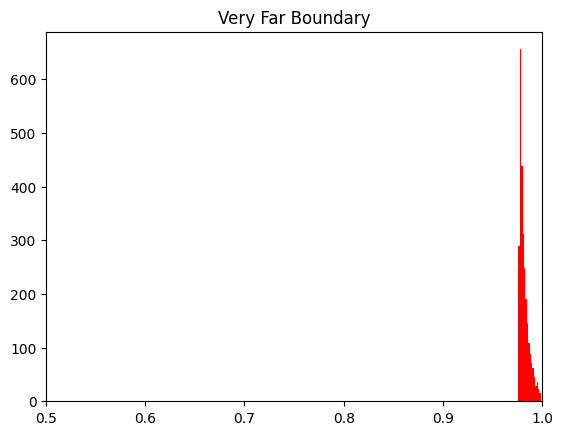

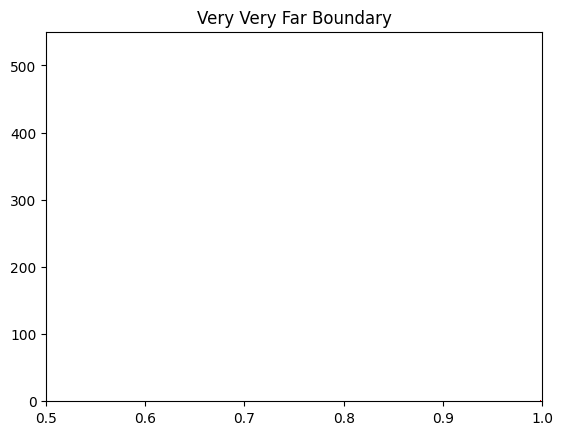

In [29]:
# plot distribution of confidence values    
def plot_confidence_distribution(confidence_values, color = "blue", title = "", xlim = [0.5, 1.0]):
    # Histogram of percentage of confidence values
    if xlim is not None:
        plt.xlim(*xlim)
    # set x limits to 0.5 to 1.0
    plt.hist(confidence_values, bins = 20, color = color)
    
    plt.title(title)
    # plt.legend()
    plt.show()
    
plot_confidence_distribution(base["confidence"], color = "blue", title = "Clean Set Confidence Distribution")
plot_confidence_distribution(adversarial["confidence"], color = "yellow", title = "Adversarial Confidence Distribution")
plot_confidence_distribution(far_boundary["confidence"], color = "orange", title = "Far Boundary")
plot_confidence_distribution(very_far_boundary["confidence"], color = "red", title = "Very Far Boundary")
plot_confidence_distribution(very_very_far_boundary["confidence"], color = "red", title = "Very Very Far Boundary")

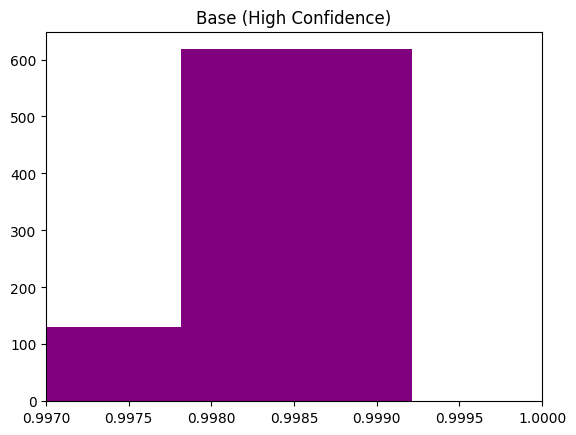

In [16]:
plot_confidence_distribution(very_high_confidence_base["confidence"], color = "purple", title = "Base (High Confidence)", xlim = [0.997, 1.0])

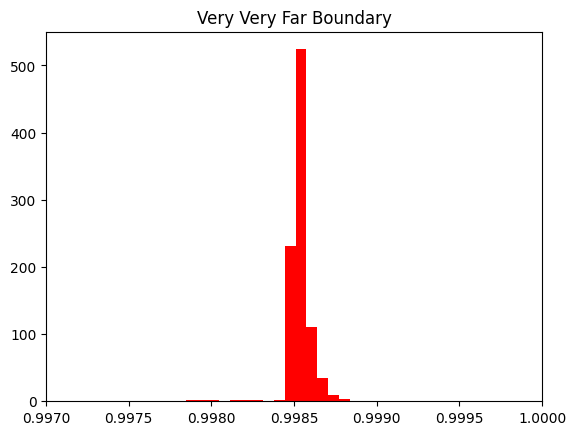

In [19]:
plot_confidence_distribution(very_very_far_boundary["confidence"], color = "red", title = "Very Very Far Boundary", xlim = [0.997, 1.0])

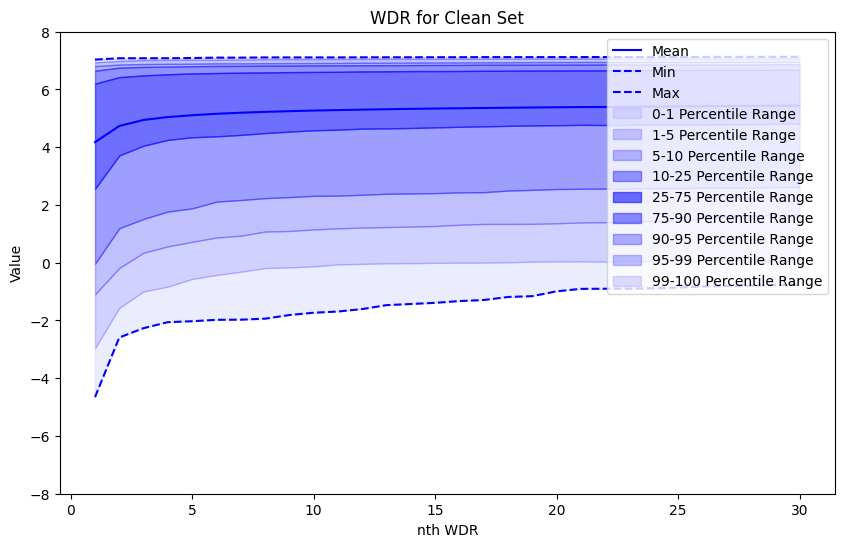

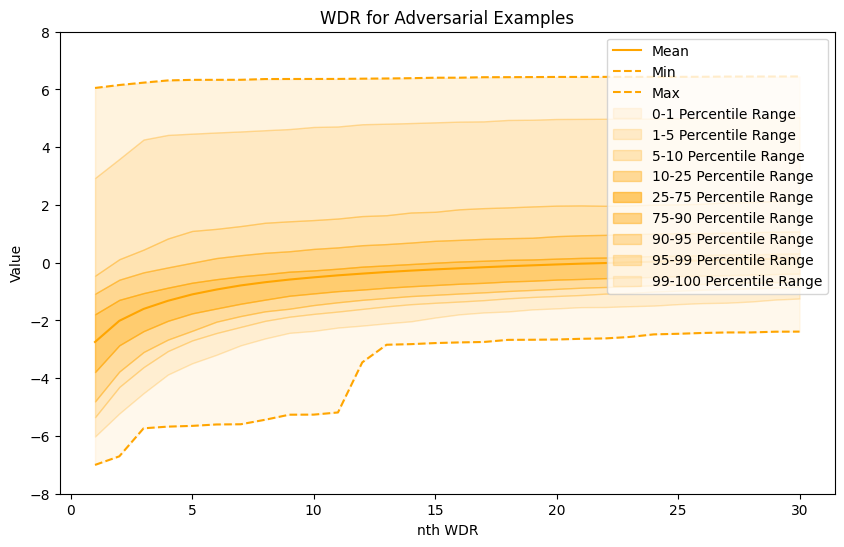

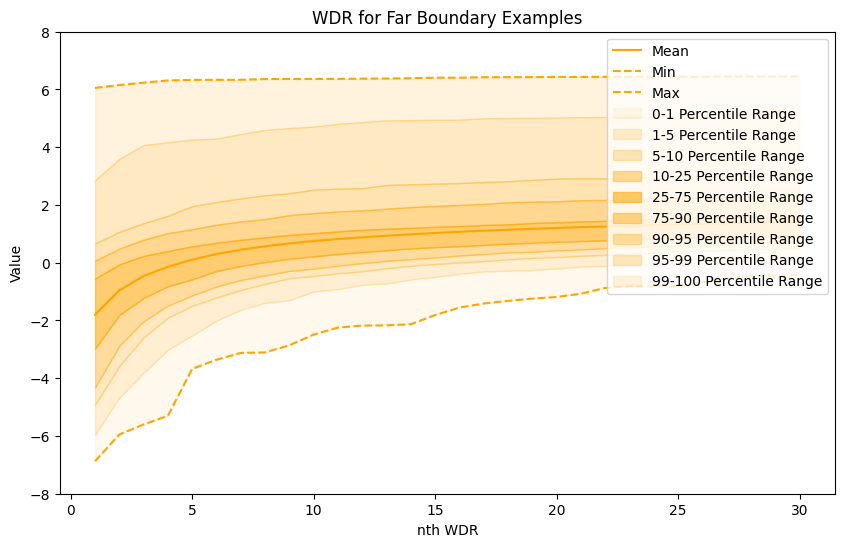

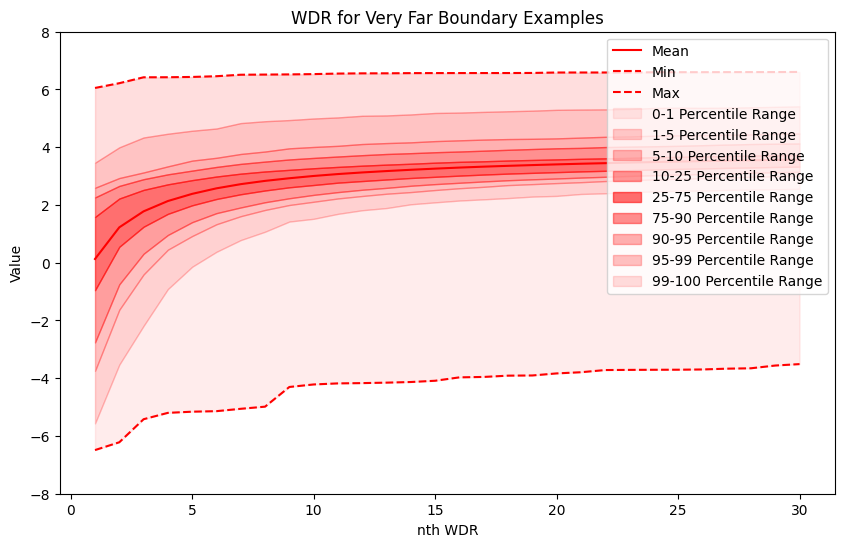

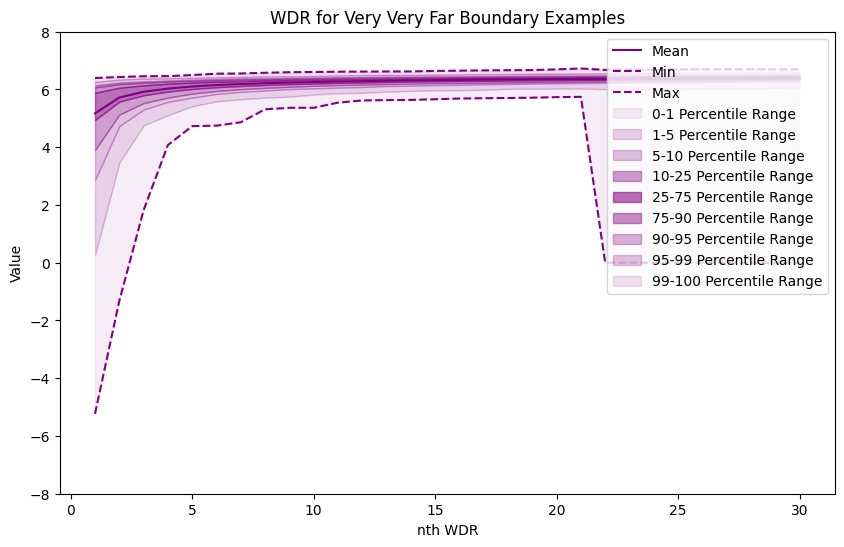

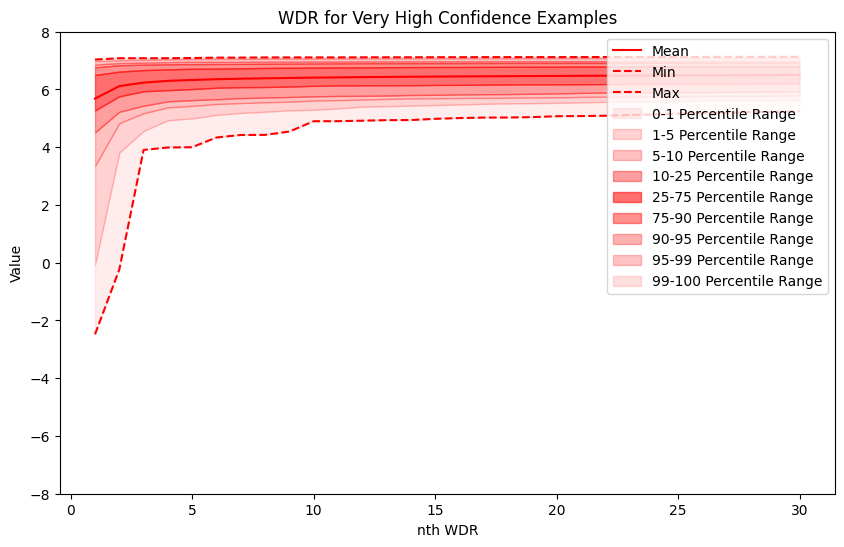

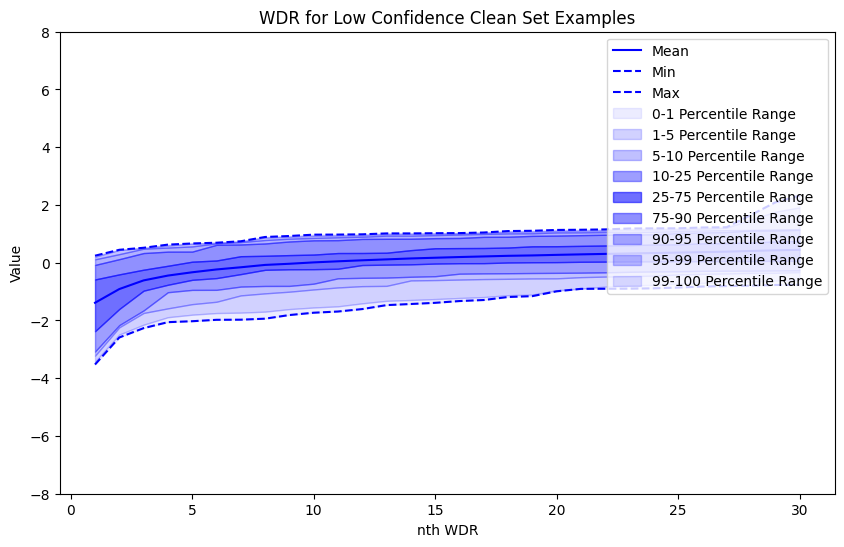

In [28]:
better_plot_wdr(base["logit_diffs"], title = "WDR for Clean Set", color = "blue", first_n = 30, y_range = [-8, 8])
better_plot_wdr(adversarial["logit_diffs"], title = "WDR for Adversarial Examples", color = "orange", first_n = 30, y_range = [-8, 8])
better_plot_wdr(far_boundary["logit_diffs"], title = "WDR for Far Boundary Examples", color = "orange", first_n = 30, y_range = [-8, 8])
better_plot_wdr(very_far_boundary["logit_diffs"], title = "WDR for Very Far Boundary Examples", color = "red", first_n = 30, y_range = [-8, 8])
better_plot_wdr(very_very_far_boundary["logit_diffs"], title = "WDR for Very Very Far Boundary Examples", color = "purple", first_n = 30, y_range = [-8, 8])

# better_plot_wdr(very_high_confidence_base["logit_diffs"], title = "WDR for High Confidence Examples", color = "purple")
better_plot_wdr(very_very_high_confidence_base["logit_diffs"], title = "WDR for Very High Confidence Examples", color = "red", first_n = 30, y_range = [-8, 8])
better_plot_wdr(low_confidence_base["logit_diffs"], title = "WDR for Low Confidence Clean Set Examples", color = "blue", first_n = 30, y_range = [-8, 8])

In [27]:
very_very_far_boundary.describe

<bound method NDFrame.describe of                                            logit_diffs  is_adversarial   
0    [5.69401169, 6.01738977, 6.02527523, 6.0614776...            True  \
1    [6.05305576, 6.18150234, 6.21173668, 6.2494859...            True   
2    [4.64300013, 4.76847649, 5.12670422, 5.2250661...            True   
3    [5.97408295, 6.24441338, 6.25944138, 6.2726101...            True   
4    [6.2670064, 6.43204784, 6.45947075, 6.46209908...            True   
..                                                 ...             ...   
945  [5.74174881, 6.35516119, 6.38525391, 6.4088611...            True   
946  [5.21798658, 5.53446674, 5.61434126, 5.6698956...            True   
947  [0.96471316, 5.54818773, 6.13446617, 6.1549997...            True   
948  [5.80316257, 5.89460135, 6.00554895, 6.0081672...            True   
949  [2.64012527, 4.67242813, 6.0087204, 6.22643757...            True   

     is_adversarial_success   
0                      True  \
1              

In [33]:
def print_text(text):
    for i in range(0, len(text), 100):
        print(text[i:i+100])

In [41]:
for i in range(1):
    print(base["text"][0])
    print("\n\n")

I love sci-fi and am willing to put up with a lot. Sci-fi movies/TV are usually underfunded, under-appreciated and misunderstood. I tried to like this, I really did, but it is to good TV sci-fi as Babylon 5 is to Star [[Trek]] (the original). Silly prosthetics, cheap cardboard sets, stilted dialogues, CG that doesn't match the background, and painfully one-dimensional characters cannot be overcome with a 'sci-fi' setting. (I'm sure there are those of you out there who think Babylon 5 is good sci-fi TV. It's not. It's clichéd and uninspiring.) While US viewers might like emotion and character development, sci-fi is a genre that does not take itself seriously (cf. Star Trek). It may treat important issues, yet not as a serious philosophy. It's really difficult to care about the characters here as they are not simply foolish, just [[missing]] a spark of life. Their actions and reactions are [[wooden]] and [[predictable]], often [[painful]] to watch. The makers of Earth KNOW it's rubbish a

In [43]:
adversarial["num_queries"]

KeyError: 'num_queries'

,logit_diffs,is_adversarial,is_adversarial_success,text,confidence
0,"[5.69401169, 6.01738977, 6.02527523, 6.0614776...",True,True,I love sci-fi and am willing to put up with a ...,0.998530
1,"[6.05305576, 6.18150234, 6.21173668, 6.2494859...",True,True,[[Valued]] [[for]] [[pleasure]] [[significance...,0.998546
2,"[4.64300013, 4.76847649, 5.12670422, 5.2250661...",True,True,its [[una]] [[unreservedly]] average [[flick]]...,0.998692
3,"[5.97408295, 6.24441338, 6.25944138, 6.2726101...",True,True,STAR RATING: ***** Saturday Night **** Friday ...,0.998539
4,"[6.2670064, 6.43204784, 6.45947075, 6.46209908...",True,False,"First off let me say, If you haven't enjoyed a...",0.998701
